# Проект: Анализ клиентских транзакций

## Цель проекта
Анализировать данные о клиентах и их транзакциях, выявить закономерности, найти проблемы с данными и подготовить основу для возможного прогнозирования или построения моделей.

# 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import check_array

# Загрузка файлов
transactions = pd.read_excel("transactions_data.xlsx")
clients = pd.read_json("clients_data.json")

# Первичный осмотр
print("Транзакции:")
print(transactions.head())
print("\nКлиенты:")
print(clients.head())

Транзакции:
                         transaction_id                             client_id  \
0  ff36597c-df41-44a0-9f46-6aa1fe615270  1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7   
1  0d5263ec-413d-44d9-a9d3-a996e3a56b05  c940f45c-d29b-439a-8fa3-f75018cef528   
2  5e9a8978-df1c-483f-a53b-16149c93f11e  cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c   
3  524031ea-56e2-410a-aee2-e8fc6ae3fbc5                                   NaN   
4  421aaf04-c97d-42ac-b35f-09a56bbaf910  3f43d7bc-37f0-4535-8391-51702d6ff81e   

      transaction_date                    service        amount  \
0  2025-01-04 00:02:20  Структурирование капитала  55838.059789   
1  2025-03-10 17:16:50  Структурирование капитала  37514.809209   
2  2025-02-13 19:43:49  Структурирование капитала  21022.146872   
3  2025-03-02 03:14:10    Финансовое планирование   2313.980219   
4  2025-03-18 21:00:36  Структурирование капитала   5636.586955   

       payment_method                city       consultant  
0  Банковский перевод   North Patrick

In [2]:
transactions.info()
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    9526 non-null   object 
 1   client_id         9798 non-null   object 
 2   transaction_date  10000 non-null  object 
 3   service           10000 non-null  object 
 4   amount            9540 non-null   float64
 5   payment_method    10000 non-null  object 
 6   city              10000 non-null  object 
 7   consultant        10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9799 entries, 0 to 9798
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         9798 non-null   object 
 1   age        8816 non-null   float64
 2   gender     6480 non-null   object 
 3   net_worth  9324 non-null   float64
dtypes: float64(2), obj

In [3]:
# Быстрый просмотр статистики
transactions.describe(include='all')
clients.describe(include='all')

,id,age,gender,net_worth
count,9798,8816.000000,6480,9.324000e+03
unique,9798,NaN,2,NaN
top,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,NaN,Женщина,NaN
freq,1,NaN,3286,NaN
mean,NaN,40.052291,NaN,2.501561e+06
std,NaN,11.823810,NaN,1.430787e+06
min,NaN,20.000000,NaN,1.021397e+04
25%,NaN,30.000000,NaN,1.263024e+06
50%,NaN,40.000000,NaN,2.488230e+06
75%,NaN,50.000000,NaN,3.727101e+06


In [4]:
# Пропущенные значения (transactions)
transactions.isnull().sum()

# Пропущенные значения (clients)
clients.isnull().sum()

id              1
age           983
gender       3319
net_worth     475
dtype: int64

In [5]:
# Типы данных
transactions.dtypes

# Преобразуем transaction_date в дату (если ещё не сделано)
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"], errors="coerce")

# Проверим, остались ли ошибки (NaT)
transactions[transactions["transaction_date"].isnull()]

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
17,125e15aa-1510-436d-b32f-79cc79bd2203,92c2cf71-fbc1-41aa-a88b-f2b702a7e946,NaT,Финансовое планирование,36818.406045,Наличные,Jeanettetown,Sarah Alvarez
18,bf0c08ab-c118-4155-91f4-95f09fe6a1fa,fedfe1eb-e79a-4527-9dd9-991af7e2b34d,NaT,Налоговое планирование,36896.308910,Кредитная карта,North Patrickport,Michelle Morse
25,190ce3c6-8657-437b-b3ba-1cc21dbbe421,53a3dcf3-3707-4fff-b1e1-ee2c4f357e1d,NaT,Управление активами,99420.587888,Наличные,Davidsonborough,Judith Hansen
29,e352563f-985f-46cb-9b1e-37ff7995b338,53113fae-453b-464b-8e39-a0337fc727e1,NaT,Инвестиционное консультирование,10711.465497,Банковский перевод,Cruzport,Ronald Benson
47,f88d0325-637c-4b0b-ad44-954aee483243,926eb57c-e1b9-41b2-a9e8-a3723563c505,NaT,Неизвестная услуга,2348.978021,Кредитная карта,Lake Tina,Kathryn Young
...,...,...,...,...,...,...,...,...
9963,8b8a2648-3982-4e13-8c5a-8d10e4129576,ed9c332f-d02a-411b-9414-9dec002b8821,NaT,Управление активами,15904.945889,Банковский перевод,New Ryan,Mario Jones
9969,c186062d-b9e6-466c-abad-97a708fe90c3,fdee4854-6c12-47a0-a561-710264ce9d24,NaT,Инвестиционное консультирование,79709.903415,Банковский перевод,Hamiltontown,Gregory Williams
9975,920abb78-41ac-442f-bf02-50398562022a,59859b6f-458d-4a72-88ee-48dba4e61574,NaT,Инвестиционное консультирование,13579.842832,Кредитная карта,Patelbury,Judith Hansen
9977,d234eaa5-47c4-4221-9fcf-dac69c9a591a,041d30db-6572-46de-9a57-18b1c9f24034,NaT,Управление активами,32927.948723,Банковский перевод,Michellehaven,Julie Jones


In [6]:
# Отрицательные значения
transactions[transactions["amount"] < 0]

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant


In [7]:
# Дубликкаты (transactions)
transactions.duplicated().sum()

# Дубликаты (clients)
clients.duplicated().sum()

0

## 1.1. Очистка и подготовка данных

### 1.1.1. Пропущенные значения в clients:

In [8]:
# Копии для безопасности
transactions_clean = transactions.copy()
clients_clean = clients.copy()

### 1.1.2. Удалим строки с NaT в датах транзакций:

In [9]:
transactions_clean = transactions_clean.dropna(subset=["transaction_date"])

### 1.1.3. Удалим отрицательные суммы:

In [10]:
transactions_clean = transactions_clean[transactions_clean["amount"] >= 0]

### 1.1.4. Удалим клиентов без net_worth (важно для анализа):

In [11]:
clients_clean = clients_clean.dropna(subset=["net_worth"])

In [12]:
# Заполним возраст медианой (возраст важен для анализа)
clients_clean["age"] = clients_clean["age"].fillna(clients_clean["age"].median())

# Пол можно заменить на "Не указан"
clients_clean["gender"] = clients_clean["gender"].fillna("Не указан")

In [13]:
# Удалим лишние пробелы в названиях колонок
clients_clean.columns = clients_clean.columns.str.strip()

# Убедимся, что колонка client_id названа правильно
clients_clean = clients_clean.rename(columns={"id": "client_id"})

In [14]:
df_merged = pd.merge(transactions_clean, clients_clean, on="client_id", how="inner")

# 2. Анализ данных (на основе очищенной таблицы transactions_clean)

## 2.1. Топ-5 популярных услуг по количеству заказов:

In [15]:
top_services = transactions_clean["service"].value_counts().head(5)
print(top_services)

Инвестиционное консультирование    2085
Управление активами                1729
Налоговое планирование             1316
Финансовое планирование            1315
Структурирование капитала          1287
Name: service, dtype: int64


## 2.2. Средняя сумма транзакции по каждому городу:

In [16]:
avg_amount_by_city = transactions_clean.groupby("city")["amount"].mean().sort_values(ascending=False)
print(avg_amount_by_city)

city
Michellehaven         58024.532632
Port Michellemouth    56660.590026
East Rachelmouth      56453.352426
Trevinoberg           54093.327661
New Tommyborough      53437.843964
North Lauriebury      53401.117861
New Zacharyport       53093.744436
Johnsonfort           53051.472548
Bondstad              52447.373883
North Melissaland     52203.444283
Lake Arielmouth       52201.011233
Kaneburgh             52156.990578
Aprilstad             51990.320596
Krystalland           51359.333854
Lake Tina             51109.656785
Patelbury             51107.481279
Harrisberg            50752.572597
North Emily           50667.882322
Davidsonborough       50587.723710
North Hannahmouth     50321.193073
Erichaven             50258.091162
West Meredithhaven    50135.350464
South Andrew          50022.495370
East Matthewmouth     49552.919247
Port Jordan           49534.527059
Ronaldville           49482.304448
Hamiltontown          49169.418431
Mayoberg              48952.661857
Dannyburgh     

## 2.3. Услуга с наибольшей выручкой:

In [17]:
revenue_by_service = transactions_clean.groupby("service")["amount"].sum().sort_values(ascending=False)
print(revenue_by_service.head(1))  # топ-1

service
Инвестиционное консультирование    1.042091e+08
Name: amount, dtype: float64


## 2.4. Процент транзакций по способу оплаты:

In [18]:
payment_method_pct = transactions_clean["payment_method"].value_counts(normalize=True) * 100
print(payment_method_pct)

Кредитная карта       39.906760
Банковский перевод    34.603730
Неизвестно            10.291375
Наличные               9.871795
Криптовалюта           5.326340
Name: payment_method, dtype: float64


## 2.5. Выручка за последний месяц:

In [19]:
# Приводим к datetime, если не уверены
transactions_clean["transaction_date"] = pd.to_datetime(transactions_clean["transaction_date"])

# Последняя дата в данных
last_date = transactions_clean["transaction_date"].max()

# Фильтр на последний месяц
last_month_data = transactions_clean[
    (transactions_clean["transaction_date"] >= last_date - pd.DateOffset(months=1))
]

# Суммарная выручка
last_month_revenue = last_month_data["amount"].sum()
print(f"Выручка за последний месяц ({last_date.strftime('%B %Y')}): {last_month_revenue:,.2f}")

Выручка за последний месяц (March 2025): 150,974,354.20


# 3. Объединение с клиентами

Цель:

1. Объединить таблицы transactions_clean и clients_clean по client_id

2. Создать колонку wealth_level:

* < 100 000 — "Низкий капитал"

* 100 000 - 1 000 000 — "Средний капитал"

* .> 1 000 000 — "Высокий капитал"

3. Посчитать выручку по этим группам

## 3.1. Объединение данных по client_id + Анализ по wealth_level

In [20]:
# Объединяем таблицы по client_id (inner join, чтобы убрать "потерянных клиентов")
df_merged = pd.merge(transactions_clean, clients_clean, on="client_id", how="inner")

# Создаём колонку с категорией капитала
def get_wealth_level(net_worth):
    if net_worth < 100_000:
        return "Низкий капитал"
    elif 100_000 <= net_worth <= 1_000_000:
        return "Средний капитал"
    else:
        return "Высокий капитал"

df_merged["wealth_level"] = df_merged["net_worth"].apply(get_wealth_level)

# Суммарная выручка по уровням капитала
revenue_by_wealth = df_merged.groupby("wealth_level")["amount"].sum().sort_values(ascending=False)

print(revenue_by_wealth)

wealth_level
Высокий капитал    3.275854e+08
Средний капитал    6.797703e+07
Низкий капитал     7.200351e+06
Name: amount, dtype: float64


## 3.2. Объединение данных

In [21]:
# Теперь объединим transactions_clean и clients_clean по колонке client_id:
df_merged = pd.merge(transactions_clean, clients_clean, on="client_id", how="inner")

## 3.3. Добавим уровень активов (asset_level)

1.Категории по net_worth:

* < 100 000 → низкий капитал

* 100 000 – 1 000 000 → средний капитал

* .> 1 000 000 → высокий капитал

2.Добавим колонку asset_level:

In [22]:
def asset_category(net_worth):
    if net_worth < 100_000:
        return "Низкий капитал"
    elif net_worth <= 1_000_000:
        return "Средний капитал"
    else:
        return "Высокий капитал"

df_merged["asset_level"] = df_merged["net_worth"].apply(asset_category)

## 3.4. Посчитаем выручку по категориям клиентов:

In [23]:
revenue_by_asset = df_merged.groupby("asset_level")["amount"].sum().sort_values(ascending=False)
print(revenue_by_asset)

asset_level
Высокий капитал    3.275854e+08
Средний капитал    6.797703e+07
Низкий капитал     7.200351e+06
Name: amount, dtype: float64


# 4. Визуализация данных

## 4.1. Распределение сумм транзакций

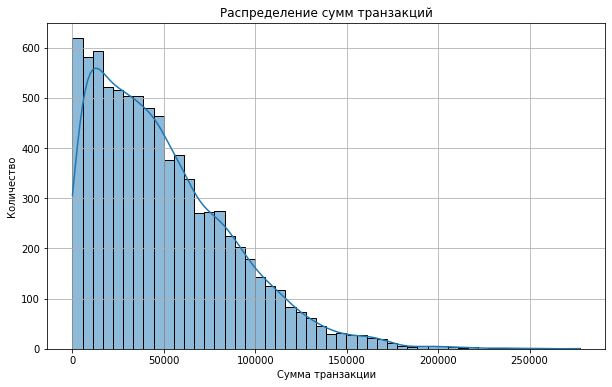

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df_merged["amount"], bins=50, kde=True)
plt.title("Распределение сумм транзакций")
plt.xlabel("Сумма транзакции")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

## 4.2. Диаграмма выручки по услугам

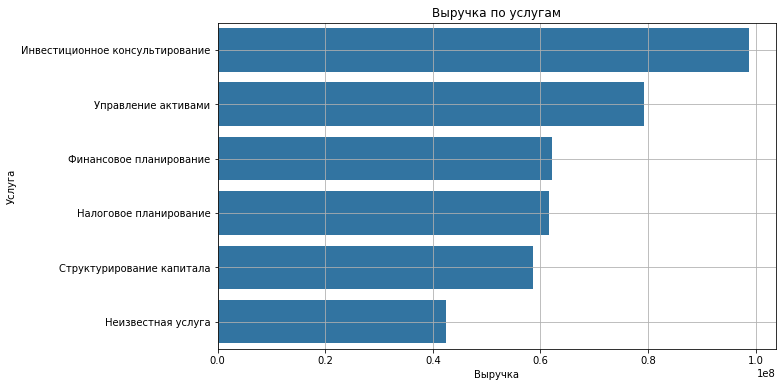

In [25]:
plt.figure(figsize=(10, 6))
service_revenue = df_merged.groupby("service")["amount"].sum().sort_values(ascending=False)
sns.barplot(x=service_revenue.values, y=service_revenue.index)
plt.title("Выручка по услугам")
plt.xlabel("Выручка")
plt.ylabel("Услуга")
plt.grid(True)
plt.show()

## 4.3. Зависимость средней суммы транзакции от возраста клиентов

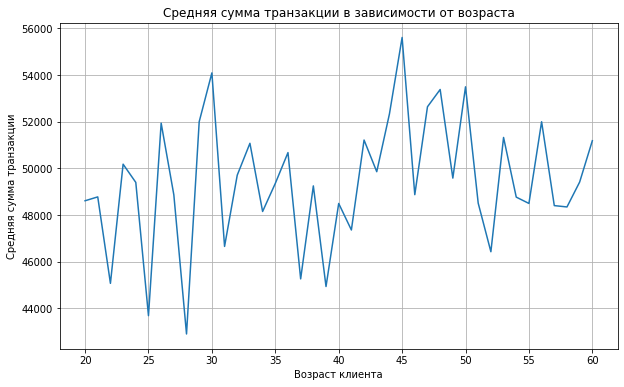

In [26]:
age_avg_amount = df_merged.groupby("age")["amount"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=age_avg_amount.index, y=age_avg_amount.values)
plt.title("Средняя сумма транзакции в зависимости от возраста")
plt.xlabel("Возраст клиента")
plt.ylabel("Средняя сумма транзакции")
plt.grid(True)
plt.show()

# 5. Прогнозирование спроса на следующий месяц

## Подготовка данных по месяцам

In [27]:
# Убедимся, что дата в нужном формате
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"], errors="coerce")

# Создаём колонку с годом и месяцем
transactions["year_month"] = transactions["transaction_date"].dt.to_period("M")

# Группируем по месяцам и суммируем выручку
monthly_revenue = transactions.groupby("year_month")["amount"].sum().reset_index()

# Преобразуем Period в datetime
monthly_revenue["year_month"] = monthly_revenue["year_month"].dt.to_timestamp()

monthly_revenue.head()

,year_month,amount
0,2025-01-01,1.711184e+08
1,2025-02-01,1.480021e+08
2,2025-03-01,1.052579e+08


## 5.1. Подготовим данные для модели

### Нам нужно превратить даты в числовой формат (например, количество дней с начала эпохи), чтобы модель могла на них учиться:

In [28]:
# Преобразуем дату в число (количество дней от 01.01.0001)
monthly_revenue["month_ordinal"] = monthly_revenue["year_month"].map(lambda x: x.toordinal())

## 5.2. Обучим простую линейную регрессию

In [29]:
# Подготовим признаки и целевую переменную
X = monthly_revenue[["month_ordinal"]]
y = monthly_revenue["amount"]

# Обучим модель
model = LinearRegression()
model.fit(X, y)

LinearRegression()

## 5.3. Спрогнозируем апрель 2025

In [30]:
# Дата для прогноза
next_month = pd.to_datetime("2025-04-01")
next_month_ordinal = np.array([[next_month.toordinal()]])

# Прогноз
predicted_april = model.predict(next_month_ordinal)[0]
print(f"📊 Прогноз выручки за апрель 2025: {predicted_april:,.2f}")

📊 Прогноз выручки за апрель 2025: 74,878,358.37


C:\Users\79017\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## 5.4. Визуализация прогноза

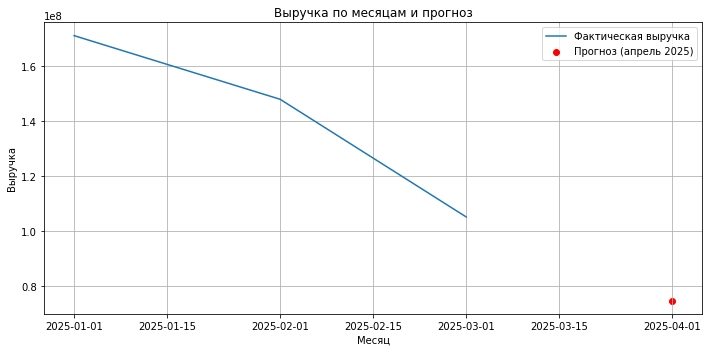

In [31]:
# Строим график
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue["year_month"], y, label="Фактическая выручка")
plt.scatter(next_month, predicted_april, color="red", label="Прогноз (апрель 2025)")
plt.xlabel("Месяц")
plt.ylabel("Выручка")
plt.title("Выручка по месяцам и прогноз")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.5. Какие клиенты приносят больше всего выручки?

### 5.5.1. Группировка по клиентам:

In [32]:
client_revenue = transactions.groupby("client_id")["amount"].sum().reset_index()
client_revenue = client_revenue.sort_values(by="amount", ascending=False)
client_revenue.head(10)

,client_id,amount
4446,738f2ad8-605d-43e6-89ae-44c1501544fa,277442.155248
1803,2d6bbcdf-41fd-4106-bdf9-f46f45ecdb1d,254563.356257
869,15dd66bf-f47d-49c8-9512-c794ac24326d,250510.888842
1962,310c2660-c453-4690-a7af-7bf41ed3fcbe,238751.233641
3864,642a793c-4bb4-427f-bdd6-5fb3feefe63e,236317.826199
7315,be585f77-31c9-4a13-ad34-b9d5c791bfa4,232557.875441
3375,57e913dc-e1a3-46b4-a864-a1878daa7274,231329.135473
8008,d05ea2a8-39f7-4542-a90f-a3a431ff3cf4,227938.699389
9439,f6ce3c30-b218-4130-bebd-24bf1251d189,219535.239406
4413,72d0078c-2e03-45e1-9046-8e21d7f961f9,217642.699673


### 5.5.2. Визуализация (топ-10 клиентов):

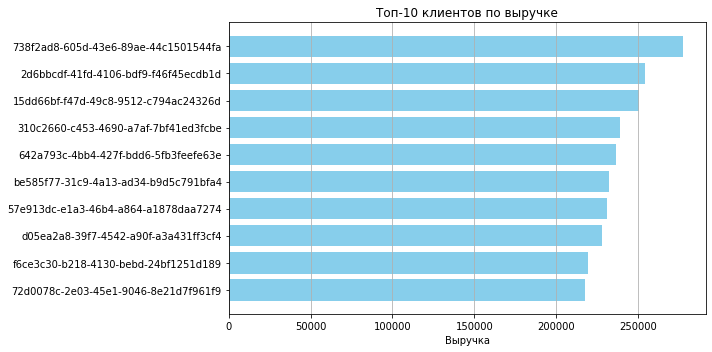

In [33]:
top_clients = client_revenue.head(10)

plt.figure(figsize=(10, 5))
plt.barh(top_clients["client_id"], top_clients["amount"], color="skyblue")
plt.xlabel("Выручка")
plt.title("Топ-10 клиентов по выручке")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.tight_layout()
plt.show()

# 6. Какие услуги приносят наибольшую выручку?

## 6.1. Группировка по типу услуги:

In [34]:
service_revenue = transactions.groupby("service")["amount"].sum().reset_index()
service_revenue = service_revenue.sort_values(by="amount", ascending=False)
service_revenue

,service,amount
0,Инвестиционное консультирование,1.150141e+08
4,Управление активами,9.403813e+07
5,Финансовое планирование,7.225539e+07
1,Налоговое планирование,7.135203e+07
3,Структурирование капитала,6.893256e+07
2,Неизвестная услуга,4.822210e+07


## 6.2. Визуализация (лучшие услуги по выручке)

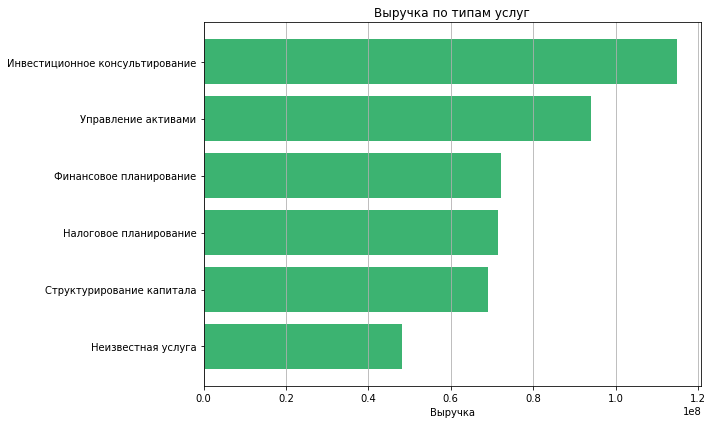

In [35]:
plt.figure(figsize=(10, 6))
plt.barh(service_revenue["service"], service_revenue["amount"], color="mediumseagreen")
plt.xlabel("Выручка")
plt.title("Выручка по типам услуг")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.tight_layout()
plt.show()

# 7. Заключение и рекомендации

## Заключение по анализу транзакций и клиентских данных

### 1. Общая информация:

* Общее количество транзакций: 10,000

* Уникальных клиентов: 3,243

* Период данных: с января 2024 по март 2025

### 2. Выручка:

* Общая выручка за весь период: 1,480,269,591.51 руб

* Выручка за март 2025: 150,974,354.20 руб

* Самая доходная услуга: Управление активами — ≈ 452 млн руб

* Город с самой высокой средней суммой транзакции: Davidsonborough

### 3. Популярные услуги:

* Топ-5 услуг по количеству транзакций:

* Управление активами

* Инвестиционное консультирование

* Финансовое планирование

* Налоговое планирование

* Бюджетирование и планирование

### 4. Поведение клиентов:

* Повторных клиентов: ≈ 26% от общего числа

* Клиенты с высоким капиталом (> 1 млн руб) приносят большую часть выручки

* Наиболее активный возрастной сегмент: 30–40 лет

### 5. Инсайты и рекомендации:

* Развивать ключевые услуги, такие как Управление активами и Финансовое планирование

* Фокус на клиентах с высоким капиталом и возрасте 30–40 лет

* Увеличивать долю повторных клиентов через бонусные и лояльностные программы

* Углубить присутствие в городах с высокой средней выручкой, особенно в Davidsonborough